

# Training Machine Learning Model File 
## This file contains the code which is used to train the machine learning model
## After the model is trained the weight of the model get saved with its best accuracy 

# **Code Reference**
## https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/3_resnet50(colab).ipynb 

In [ ]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
import cv2
from tensorflow.python.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,Flatten
from keras import applications
from keras.applications import ResNet50
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras import optimizers,Model,Sequential
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from multiprocessing.pool import ThreadPool
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
%matplotlib inline
from tqdm import tqdm
from prettytable import PrettyTable
import pickle
import multiprocessing
import seaborn as sns
plt.rcParams["axes.grid"] = False
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from PIL import Image
from keras.models import model_from_json





# The Functions
the program uses various functions to deal with different activties throughout in order to successfully train the machine learning model 


In [ ]:
#This Function loads the train/test data from a folder and cvs file into variables
def load_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('./','train_images/')
    test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

These next Functions deal with Processing The Images to produce an results of higher accuracy 


In [ ]:
'''Function loads an image from Folder , Resizes and saves in another directory '''

def image_resize_save(values):
    for i in values:
      input_filepath = os.path.join('./','test_images','{}'.format(i))
      output_filepath = os.path.join('./','test_images_resized','{}'.format(i))
      img = cv2.imread(input_filepath)
      cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))


In [ ]:
#Function from image from bac background
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
#function provides circle crop on the image
def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(values):
    for i in values: 
      input_filepath = os.path.join('./','train_images_resized','{}'.format(i))
      output_filepath = os.path.join('./','train_images_resized_preprocessed','{}'.format(i))
      
      img = cv2.imread(input_filepath)
      height, width, channels = img.shape
      img = circle_crop(img) 
      cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))


Next Functions are used to successfully train the model


In [ ]:
#Data generator is used to load in and Augment the data before training the model various augmentations are used 
def img_generator(train,test):
  #hirizontal flip, validation split and rescale augemntations are applied 
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    #function retuns the image data generators 
    return train_generator,valid_generator,test_generator

In [ ]:
#this function create the resnet50 model with iniall imagenet weights without the top layer 
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

Main code of the program underneath declaring variables and using the functions to process the images and train the model 

In [ ]:
#Declearing important variables 
IMG_SIZE = 512
BATCH_SIZE = 8
EPOCHS = 25
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
#variables used for callbacks
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
#load in the directories 
train_dir = "train_images/"
val_dir   = "backend/test_images/" #directories for training

test_dir  = "backend/val/" #directory for final model scoring

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
print("We are currently in the folder of ",os.getcwd())


We are currently in the folder of  /content/drive/MyDrive/Colab Notebooks


In [ ]:
#load data into dataframes
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_test.head(6)
image_resize_save(df_test.file_name.values)
#preprocess_image(df_train.file_name.values)

(3662, 4) (1928, 3) 



,id_code,file_path,file_name
0,0005cfc8afb6,./test_images/0005cfc8afb6.png,0005cfc8afb6.png
1,003f0afdcd15,./test_images/003f0afdcd15.png,003f0afdcd15.png
2,006efc72b638,./test_images/006efc72b638.png,006efc72b638.png
3,00836aaacf06,./test_images/00836aaacf06.png,00836aaacf06.png
4,009245722fa4,./test_images/009245722fa4.png,009245722fa4.png
5,009c019a7309,./test_images/009c019a7309.png,009c019a7309.png


In [ ]:
df_train_train,df_train_valid = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_valid.shape)
df_train_train.head(6)

(2929, 4) (733, 4)


,id_code,diagnosis,file_path,file_name
1951,896ad584a841,0,./train_images/896ad584a841.png,896ad584a841.png
3548,f7116e7b2f4e,0,./train_images/f7116e7b2f4e.png,f7116e7b2f4e.png
1,001639a390f0,4,./train_images/001639a390f0.png,001639a390f0.png
876,3f73c91b7e32,1,./train_images/3f73c91b7e32.png,3f73c91b7e32.png
2505,adb56cecafaf,3,./train_images/adb56cecafaf.png,adb56cecafaf.png
1725,7a06ea127e02,0,./train_images/7a06ea127e02.png,7a06ea127e02.png


In [ ]:
N_CLASSES = df_train_train['diagnosis'].nunique()

In [ ]:
#initalise the generators 
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_valid)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
#create the model
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [ ]:
#run some warm up epochs 
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
293/293 [==============================] - 1135s 4s/step - loss: 2.4960 - accuracy: 0.3718 - val_loss: 1.2631 - val_accuracy: 0.5086
Epoch 2/2
293/293 [==============================] - 34s 117ms/step - loss: 1.4321 - accuracy: 0.4296 - val_loss: 1.2447 - val_accuracy: 0.5086


In [ ]:


for layer in model.layers:
    layer.trainable = True
#Create callback which will make sure the training will stop when the best accuracy is achieved through the training 
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
#this sepcific callback will save the models best accuracy 
savepoint = ModelCheckpoint("test_best_model.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)


callback_list = [es, rlrop, savepoint]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
#initalise the model before running the training 
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#run the training of the model using train_generator , valid_generator and callback_list
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks= callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
293/293 [==============================] - 72s 224ms/step - loss: 0.5515 - accuracy: 0.6044 - val_loss: 0.4486 - val_accuracy: 0.5086

Epoch 00001: loss improved from inf to 0.34077, saving model to test_best_model.h5
Epoch 2/25
293/293 [==============================] - 65s 223ms/step - loss: 0.2301 - accuracy: 0.7457 - val_loss: 0.3850 - val_accuracy: 0.5702

Epoch 00002: loss improved from 0.34077 to 0.23280, saving model to test_best_model.h5
Epoch 3/25
293/293 [==============================] - 65s 223ms/step - loss: 0.2053 - accuracy: 0.7544 - val_loss: 0.3162 - val_accuracy: 0.6455

Epoch 00003: loss improved from 0.23280 to 0.20625, saving model to test_best_model.h5
Epoch 4/25
293/293 [==============================] - 65s 222ms/step - loss: 0.1771 - accuracy: 0.8038 - val_loss: 0.2487 - val_accuracy: 0.7705

Epoch 00004: loss improved from 0.20625 to 0.17933, saving model to test_best_model.h5
Epoch 5/25
293/293 [==============================] - 65s 222ms/step - l

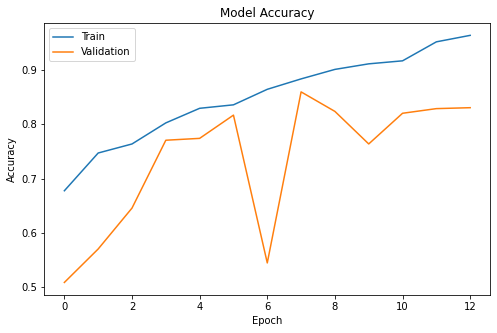

In [ ]:
#the image below shows the progress of accuracy of the model with the training data as well as with the validation data that have never been seen before
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
#complete generator meaning run predictions of train data to determine accuracy with data familiar to the model and to determine Cohen Kappa Score
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2929/2929 [==============================] - 49s 16ms/step


In [ ]:
#Print the calculated accuracy and the Cohen Kappa score 
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.949
Train Accuracy score : 0.910


In [ ]:
#save the model structure 
model.save('model')